# MNIST

In [118]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
import time
import numpy as np
import matplotlib.pyplot as plt

In [119]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
print("device: ", device)
print('cuda index:', torch.cuda.current_device())
print('gpu 개수:', torch.cuda.device_count())
print('graphic name:', torch.cuda.get_device_name())
cuda = torch.device('cuda')
print(cuda)

device:  cuda
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA GeForce GTX 1080 Ti
cuda


In [120]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [121]:
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=50,
                                          shuffle=True,
                                          drop_last=True)
total_batch = len(data_loader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 1200


In [122]:
class MNIST(nn.Module):
    def __init__(self):
        super(MNIST, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Linear(7 * 7 * 64, 128, bias=True),
            torch.nn.ReLU())
        self.layer4 = torch.nn.Sequential(
            torch.nn.Linear(128, 10, bias=True),
            torch.nn.LogSoftmax(dim = 1))
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)   # Flatten
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [123]:
model_mnist = MNIST().to(device)

In [124]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_mnist.parameters(), lr=0.001)

In [126]:
for epoch in range(3):
    avg_cost = 0

    start_time = time.time()
    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model_mnist(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    end_time = time.time()
    print('[Epoch: {:>4}] cost = {:>.9} Time : {:.3}'.format(epoch + 1, avg_cost, end_time - start_time))

[Epoch:    1] cost = 0.0718275383 Time : 7.8
[Epoch:    2] cost = 0.0402652137 Time : 7.77
[Epoch:    3] cost = 0.0287957266 Time : 7.7


In [79]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model_mnist(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9850999712944031


C:\Users\SanghyunPark\anaconda3\envs\deep_learning_torch\Lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\SanghyunPark\anaconda3\envs\deep_learning_torch\Lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


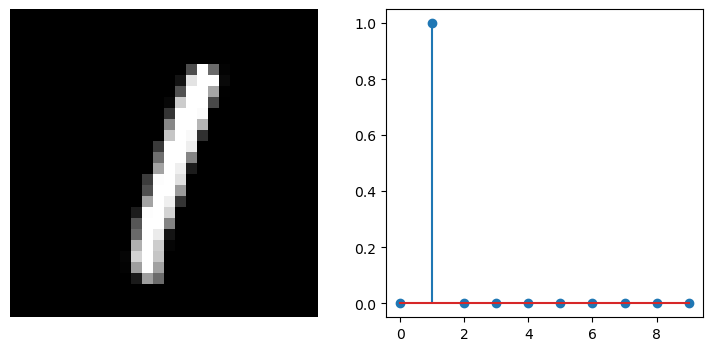

Prediction : 1
True Label : 1


In [104]:
with torch.no_grad():
    num = 5
    test_img = X_test[num:num+1]
    test_label = mnist_test.test_labels[num]
    predict = model_mnist(test_img)
    mypred = torch.argmax(predict, axis = 1).cpu().numpy()
    
    plt.figure(figsize = (9, 4))
    
    plt.subplot(1,2,1)
    plt.imshow(test_img.cpu().reshape(28, 28), 'gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.stem(torch.exp(predict[0].cpu())) # softmax를 log로 했으므로..
    plt.show()
    
    print('Prediction : {}'.format(mypred[0]))
    print('True Label : {}'.format(test_label))

# Steel Surface Defects

In [153]:
train_x = np.load('./NEU_train_imgs.npy')
train_y = np.load('./NEU_train_labels.npy')
test_x = np.load('./NEU_test_imgs.npy')
test_y = np.load('./NEU_test_labels.npy')

In [154]:
train_x = np.moveaxis(train_x, 3, 1)
test_x = np.moveaxis(test_x, 3, 1)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1500, 1, 200, 200)
(1500,)
(300, 1, 200, 200)
(300,)


In [155]:
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([1500, 1, 200, 200])
torch.Size([1500])
torch.Size([300, 1, 200, 200])
torch.Size([300])


In [156]:
from torch.utils.data import TensorDataset

In [157]:
dataset = TensorDataset(train_x, train_y)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True, drop_last=True)

In [170]:
class STEEL(nn.Module):
    def __init__(self):
        super(STEEL, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same'), # 200 x 200 image
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = torch.nn.Sequential(
            torch.nn.Linear(25 * 25 * 128, 128, bias=True),
            torch.nn.ReLU())
        self.layer5 = torch.nn.Sequential(
            torch.nn.Linear(128, 6, bias=True),
            torch.nn.LogSoftmax(dim = 1))
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)   # Flatten
        x = self.layer4(x)
        x = self.layer5(x)
        return x

In [171]:
model_steel = STEEL().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_steel.parameters(), lr=0.001)

In [172]:
for epoch in range(10):
    avg_cost = 0

    start_time = time.time()
    for X, Y in dataloader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model_steel(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    end_time = time.time()
    print('[Epoch: {:>4}] cost = {:>.9} Time : {:.3}'.format(epoch + 1, avg_cost, end_time - start_time))

[Epoch:    1] cost = 0.0332574435 Time : 1.81
[Epoch:    2] cost = 0.018576825 Time : 1.53
[Epoch:    3] cost = 0.0106422873 Time : 1.55
[Epoch:    4] cost = 0.00865653343 Time : 1.54
[Epoch:    5] cost = 0.0063774297 Time : 1.57
[Epoch:    6] cost = 0.00599482143 Time : 1.52
[Epoch:    7] cost = 0.00490205316 Time : 1.52
[Epoch:    8] cost = 0.00426308531 Time : 1.52
[Epoch:    9] cost = 0.00452930108 Time : 1.53
[Epoch:   10] cost = 0.00306343776 Time : 1.52


In [173]:
with torch.no_grad():
    X_test = test_x.view(len(test_x), 1, 200, 200).float().to(device)
    print(X_test.shape)
    Y_test = test_y.to(device)

    prediction = model_steel(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

torch.Size([300, 1, 200, 200])
Accuracy: 0.9466667175292969


torch.Size([300, 1, 200, 200])
torch.Size([300, 1, 200, 200])
torch.Size([1, 1, 200, 200])


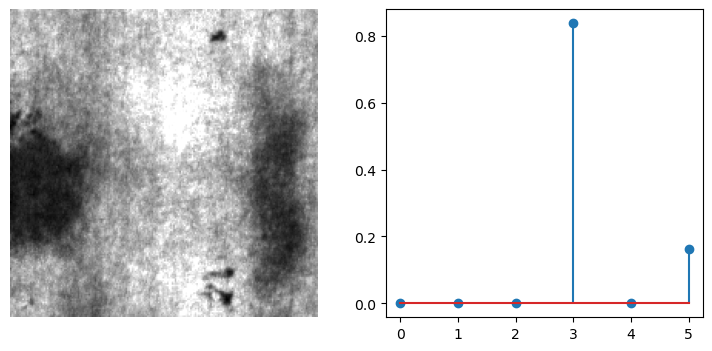

Prediction : 3 patches
True Label : 3 patches


In [215]:
with torch.no_grad():
    name = ['scratches', 'rolled-in scale', 'pitted surface', 'patches', 'inclusion', 'crazing']
    idx = np.random.choice(test_x.shape[0], 1)

    print(test_x.shape)
    X_test_ = test_x.view(len(test_x), 1, 200, 200).float().to(device)
    print(X_test_.shape)
    test_img = X_test[idx].to(device)
    print(test_img.shape)
    test_label = test_y[idx].numpy()
    
    predict = model_steel(test_img)
    mypred = torch.argmax(predict, axis = 1).cpu().numpy()
    
    plt.figure(figsize = (9, 4))
    
    plt.subplot(1,2,1)
    plt.imshow(test_img.cpu().reshape(200, 200), 'gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.stem(torch.exp(predict[0].cpu())) # softmax를 log로 했으므로..
    plt.show()
    
    print('Prediction : {} {}'.format(mypred[0], name[mypred[0]]))
    print('True Label : {} {}'.format(test_label[0], name[test_label[0]]))